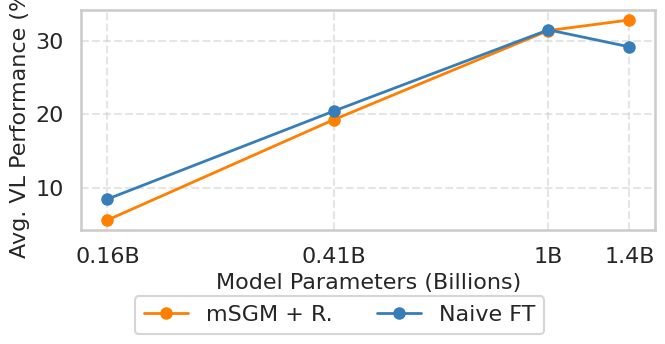

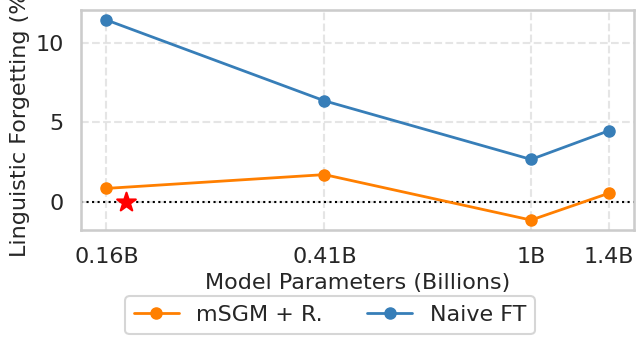

In [30]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import hmean

# Define a small epsilon value to replace zeros
EPSILON = 1e-3

# Define the dataset stages and the corresponding labels
stages = ["Task 2 (Instruct)", "Task 3 (VQA)", "Task 4 (OCR)", "Task 5 (Ref)"]
nlu_nlg_datasets = ["wsc273", "winogrande", "lambada_standard", "arc_easy", "arc_challenge"]
vl_datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa", "refcoco"]
vl_evaluate_sequence = [["vqa-v2"], ["vqa-v2", "gqa"], ["vqa-v2", "gqa", "textvqa-ocr", "textvqa-pure"], ["vqa-v2", "gqa", "textvqa-ocr", "textvqa-pure", "refcoco"]]

# Define explicit mappings for LLaVA, Our methods, and Base LLM
llava_mapping = {
    "0.16b": ["cl-instruct-stage-0-pythia+160m", "cl-vqa-stage-1-pythia+160m", "cl-ocr-stage-2-pythia+160m", "cl-ref-stage-3-pythia+160m"],
    "0.41b": ["cl-instruct-stage-0-pythia+410m", "cl-vqa-stage-1-pythia+410m", "cl-ocr-stage-2-pythia+410m", "cl-ref-stage-3-pythia+410m"],
    "1b": ["cl-instruct-stage-0-pythia+1b", "cl-vqa-stage-1-pythia+1b", "cl-ocr-stage-2-pythia+1b", "cl-ref-stage-3-pythia+1b"],
    "1.4b": ["cl-instruct-stage-0-pythia+1p4b", "cl-vqa-stage-1-pythia+1p4b", "cl-ocr-stage-2-pythia+1p4b", "cl-ref-stage-3-pythia+1p4b"],
}

our_mapping = {
    "0.16b": ["cl-instruct-stage-0-pythia+160m-sgm", "cl-vqa-stage-1-pythia+160m-sgm-rehearsal1", "cl-ocr-stage-2-pythia+160m-sgm-rehearsal1", "cl-ref-stage-3-pythia+160m-sgm-rehearsal1"],
    "0.41b": ["cl-instruct-stage-0-pythia+410m-sgm", "cl-vqa-stage-1-pythia+410m-sgm-rehearsal1", "cl-ocr-stage-2-pythia+410m-sgm-rehearsal1", "cl-ref-stage-3-pythia+410m-sgm-rehearsal1"],
    "1b": ["cl-instruct-stage-0-pythia+1b-sgm", "cl-vqa-stage-1-pythia+1b-sgm-rehearsal1", "cl-ocr-stage-2-pythia+1b-sgm-rehearsal1", "cl-ref-stage-3-pythia+1b-sgm-rehearsal1"],
    "1.4b": ["cl-instruct-stage-0-pythia+1p4b-sgm", "cl-vqa-stage-1-pythia+1p4b-sgm-rehearsal1", "cl-ocr-stage-2-pythia+1p4b-sgm-rehearsal1", "cl-ref-stage-3-pythia+1p4b-sgm-rehearsal1"],
}

base_llm_mapping = {
    "0.16b": "reproduction-align-pythia+160m",
    "0.41b": "reproduction-align-pythia+410m",
    "1b": "reproduction-align-pythia+1b",
    "1.4b": "reproduction-align-pythia+1p4b",
}

# Load the JSON data from the results file
with open('results_nlp.json', 'r') as file:
    results = json.load(file)

# Function to replace None values with a small positive value
def replace_none_and_zeros(arr, epsilon=EPSILON):
    return [epsilon if (x is None or np.isnan(x) or x == 0) else x for x in arr]

# Function to calculate performance changes and averages for each CL run
def calculate_performance(cl_runs, base_llm_mapping, results):
    performance = {}
    performance_change = {}

    for scale, run_ids in cl_runs.items():
        base_run_id = base_llm_mapping[scale]
        baseline_results = results.get(base_run_id)

        if not baseline_results:
            raise ValueError(f"Baseline run ID '{base_run_id}' not found in results.")

        changes = {}
        performances = {}
        for i, run_id in enumerate(run_ids):
            current_results = results.get(run_id)
            if not current_results:
                print(f"Run '{run_id}' missing for model '{scale}'")
                continue

            vl_evaluate_datasets = vl_evaluate_sequence[i]
            vl_scores = replace_none_and_zeros([current_results.get(dataset, np.nan) for dataset in vl_evaluate_datasets])
            baseline_vl_scores = replace_none_and_zeros([baseline_results.get(dataset, np.nan) for dataset in vl_evaluate_datasets])
            avg_acc_vl = hmean(vl_scores)
            avg_delta_vl = hmean(baseline_vl_scores) - avg_acc_vl

            nl_scores = replace_none_and_zeros([current_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
            baseline_nl_scores = replace_none_and_zeros([baseline_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
            avg_acc_nl = hmean(nl_scores)
            avg_delta_nl = hmean(baseline_nl_scores) - avg_acc_nl

            performances[f'stage_{i}_avg'] = {'VL': avg_acc_vl, 'NL': avg_acc_nl}
            changes[f'stage_{i}_avg'] = {'VL': avg_delta_vl, 'NL': avg_delta_nl}

        performance[scale] = performances
        performance_change[scale] = changes

    return performance, performance_change

# Calculate performance for our method and LLaVA method
our_performance, our_performance_change = calculate_performance(our_mapping, base_llm_mapping, results)
llava_performance, llava_performance_change = calculate_performance(llava_mapping, base_llm_mapping, results)

# Function to get average performance for plotting
def get_avg_performance_and_forgetting(performance, change, model_scales):
    avg_vl_performance = []
    avg_nl_forgetting = []
    for scale in model_scales:
        vl_scores = [performance[scale][f'stage_{i}_avg']['VL'] * 100 for i in range(1, 4)]  # Excluding Task 2 (Instruct)
        avg_vl_performance.append(np.mean(vl_scores))
        nl_deltas = [change[scale][f'stage_{i}_avg']['NL'] * 100 for i in range(4)]
        avg_nl_forgetting.append(np.mean(nl_deltas))
    return avg_vl_performance, avg_nl_forgetting

model_scales = ["0.16b", "0.41b", "1b", "1.4b"]

our_avg_vl_performance, our_avg_nl_forgetting = get_avg_performance_and_forgetting(our_performance, our_performance_change, model_scales)
llava_avg_vl_performance, llava_avg_nl_forgetting = get_avg_performance_and_forgetting(llava_performance, llava_performance_change, model_scales)

# Plotting the performance
sns.set(style="whitegrid")
sns.set_palette("muted")
sns.set_context("talk")
plt.rcParams.update({
    'axes.labelsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'figure.figsize': [7, 4],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

# Define colorblind-friendly palette
CB_palette = ['#377EB8', '#FF7F00', '#4DAF4A', '#F781BF']
# Plot Avg. VL Performance for Soft Targets and LLaVA
scale_to_label = {"0.16b": "0.16B", "0.41b": "0.41B", "1b": "1B", "1.4b": "1.4B"}

# Plot Avg. VL Performance
plt.figure()
plt.xscale('log')
line1, = plt.plot([0.16, 0.41, 1.0, 1.4], our_avg_vl_performance, color=CB_palette[1], marker='o', linestyle='-')
line2, = plt.plot([0.16, 0.41, 1.0, 1.4], llava_avg_vl_performance, color=CB_palette[0], marker='o', linestyle='-')

plt.xticks([0.16, 0.41, 1.0, 1.4], ['0.16B', '0.41B', '1B', '1.4B'])
plt.xlabel('Model Parameters (Billions)')
plt.ylabel('Avg. VL Performance (%)')

plt.legend(handles=[line1, line2], labels=['mSGM + R.', 'Naive FT'], loc='upper center', bbox_to_anchor=(0.45, -0.25), ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig('avg_vl_performance.png', dpi=300)

# Plot Avg. Linguistic Forgetting
plt.figure()
plt.xscale('log')
line1, = plt.plot([0.16, 0.41, 1.0, 1.4], our_avg_nl_forgetting, color=CB_palette[1], marker='o', linestyle='-')
line2, = plt.plot([0.16, 0.41, 1.0, 1.4], llava_avg_nl_forgetting, color=CB_palette[0], marker='o', linestyle='-')

plt.xticks([0.16, 0.41, 1.0, 1.4], ['0.16B', '0.41B', '1B', '1.4B'])
plt.xlabel('Model Parameters (Billions)')
plt.ylabel('Linguistic Forgetting (%)')

# Highlight the 0 horizontal line
plt.axhline(0, color='black', linestyle=':', linewidth=1.5, zorder=1)
plt.scatter(0.174, 0, color='red', marker='*', s=200, zorder=5)

plt.legend(handles=[line1, line2], labels=['mSGM + R.', 'Naive FT'], loc='upper center', bbox_to_anchor=(0.45, -0.25), ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig('avg_nl_forgetting.png', dpi=300)

plt.show()


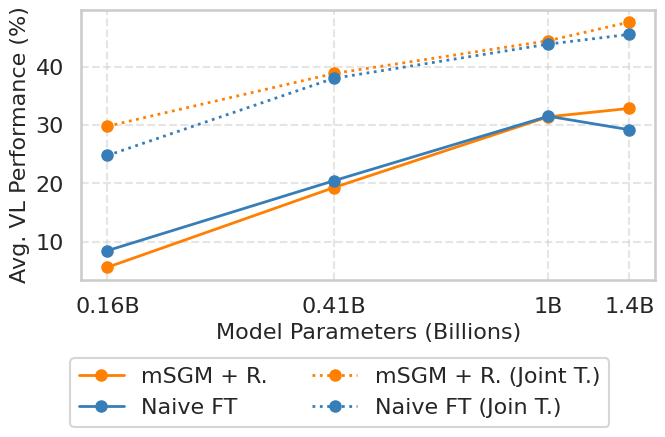

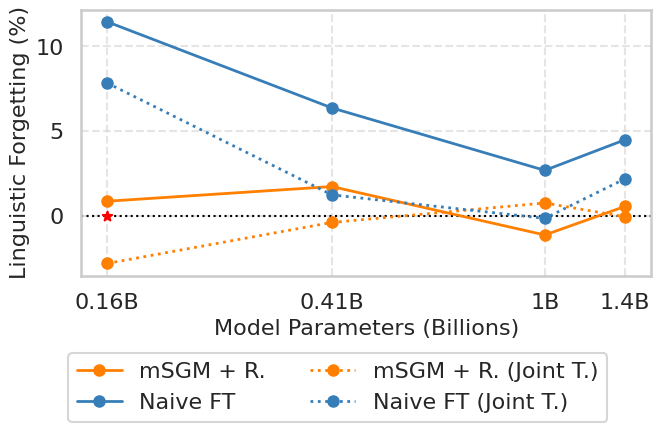

In [4]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import hmean

# Define a small epsilon value to replace zeros
EPSILON = 1e-3

# Define the dataset stages and the corresponding labels
stages = ["Task 2 (Instruct)", "Task 3 (VQA)", "Task 4 (OCR)", "Task 5 (Ref)"]
nlu_nlg_datasets = ["wsc273", "winogrande", "lambada_standard", "arc_easy", "arc_challenge"]
vl_datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa", "refcoco"]
vl_evaluate_sequence = [["vqa-v2"], ["vqa-v2", "gqa"], ["vqa-v2", "gqa", "textvqa-ocr", "textvqa-pure"], ["vqa-v2", "gqa", "textvqa-ocr", "textvqa-pure", "refcoco"]]

# Define explicit mappings for LLaVA, Our methods, and Base LLM
llava_mapping = {
    "0.16b": ["cl-instruct-stage-0-pythia+160m", "cl-vqa-stage-1-pythia+160m", "cl-ocr-stage-2-pythia+160m", "cl-ref-stage-3-pythia+160m"],
    "0.41b": ["cl-instruct-stage-0-pythia+410m", "cl-vqa-stage-1-pythia+410m", "cl-ocr-stage-2-pythia+410m", "cl-ref-stage-3-pythia+410m"],
    "1b": ["cl-instruct-stage-0-pythia+1b", "cl-vqa-stage-1-pythia+1b", "cl-ocr-stage-2-pythia+1b", "cl-ref-stage-3-pythia+1b"],
    "1.4b": ["cl-instruct-stage-0-pythia+1p4b", "cl-vqa-stage-1-pythia+1p4b", "cl-ocr-stage-2-pythia+1p4b", "cl-ref-stage-3-pythia+1p4b"],
}

our_mapping = {
    "0.16b": ["cl-instruct-stage-0-pythia+160m-sgm", "cl-vqa-stage-1-pythia+160m-sgm-rehearsal1", "cl-ocr-stage-2-pythia+160m-sgm-rehearsal1", "cl-ref-stage-3-pythia+160m-sgm-rehearsal1"],
    "0.41b": ["cl-instruct-stage-0-pythia+410m-sgm", "cl-vqa-stage-1-pythia+410m-sgm-rehearsal1", "cl-ocr-stage-2-pythia+410m-sgm-rehearsal1", "cl-ref-stage-3-pythia+410m-sgm-rehearsal1"],
    "1b": ["cl-instruct-stage-0-pythia+1b-sgm", "cl-vqa-stage-1-pythia+1b-sgm-rehearsal1", "cl-ocr-stage-2-pythia+1b-sgm-rehearsal1", "cl-ref-stage-3-pythia+1b-sgm-rehearsal1"],
    "1.4b": ["cl-instruct-stage-0-pythia+1p4b-sgm", "cl-vqa-stage-1-pythia+1p4b-sgm-rehearsal1", "cl-ocr-stage-2-pythia+1p4b-sgm-rehearsal1", "cl-ref-stage-3-pythia+1p4b-sgm-rehearsal1"],
}

base_llm_mapping = {
    "0.16b": "reproduction-align-pythia+160m",
    "0.41b": "reproduction-align-pythia+410m",
    "1b": "reproduction-align-pythia+1b",
    "1.4b": "reproduction-align-pythia+1p4b",
}

# Load the JSON data from the results file
with open('results_nlp.json', 'r') as file:
    results = json.load(file)

# Function to replace None values with a small positive value
def replace_none_and_zeros(arr, epsilon=EPSILON):
    return [epsilon if (x is None or np.isnan(x) or x == 0) else x for x in arr]

# Function to calculate performance changes and averages for each CL run
def calculate_performance(cl_runs, base_llm_mapping, results):
    performance = {}
    performance_change = {}

    for scale, run_ids in cl_runs.items():
        base_run_id = base_llm_mapping[scale]
        baseline_results = results.get(base_run_id)

        if not baseline_results:
            raise ValueError(f"Baseline run ID '{base_run_id}' not found in results.")

        changes = {}
        performances = {}
        for i, run_id in enumerate(run_ids):
            current_results = results.get(run_id)
            if not current_results:
                print(f"Run '{run_id}' missing for model '{scale}'")
                continue

            vl_evaluate_datasets = vl_evaluate_sequence[i]
            vl_scores = replace_none_and_zeros([current_results.get(dataset, np.nan) for dataset in vl_evaluate_datasets])
            baseline_vl_scores = replace_none_and_zeros([baseline_results.get(dataset, np.nan) for dataset in vl_evaluate_datasets])
            avg_acc_vl = hmean(vl_scores)
            avg_delta_vl = hmean(baseline_vl_scores) - avg_acc_vl

            nl_scores = replace_none_and_zeros([current_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
            baseline_nl_scores = replace_none_and_zeros([baseline_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
            avg_acc_nl = hmean(nl_scores)
            avg_delta_nl = hmean(baseline_nl_scores) - avg_acc_nl

            performances[f'stage_{i}_avg'] = {'VL': avg_acc_vl, 'NL': avg_acc_nl}
            changes[f'stage_{i}_avg'] = {'VL': avg_delta_vl, 'NL': avg_delta_nl}

        performance[scale] = performances
        performance_change[scale] = changes

    return performance, performance_change

# Calculate performance for our method and LLaVA method
our_performance, our_performance_change = calculate_performance(our_mapping, base_llm_mapping, results)
llava_performance, llava_performance_change = calculate_performance(llava_mapping, base_llm_mapping, results)

# Function to get average performance for plotting
def get_avg_performance_and_forgetting(performance, change, model_scales):
    avg_vl_performance = []
    avg_nl_forgetting = []
    for scale in model_scales:
        vl_scores = [performance[scale][f'stage_{i}_avg']['VL'] * 100 for i in range(1, 4)]  # Excluding Task 2 (Instruct)
        avg_vl_performance.append(np.mean(vl_scores))
        nl_deltas = [change[scale][f'stage_{i}_avg']['NL'] * 100 for i in range(4)]
        avg_nl_forgetting.append(np.mean(nl_deltas))
    return avg_vl_performance, avg_nl_forgetting

model_scales = ["0.16b", "0.41b", "1b", "1.4b"]

our_avg_vl_performance, our_avg_nl_forgetting = get_avg_performance_and_forgetting(our_performance, our_performance_change, model_scales)
llava_avg_vl_performance, llava_avg_nl_forgetting = get_avg_performance_and_forgetting(llava_performance, llava_performance_change, model_scales)

# Load the JSON data from the reference file
with open('results_A.json', 'r') as f:
    ref_results = json.load(f)

# Define the filtering criteria and datasets for the reference data
nlu_datasets = ["wsc273", "winogrande", "arc_easy", "arc_challenge"]
nlg_datasets = ["lambada_standard"]
vl_datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa"]
all_nlp_datasets = nlu_datasets + nlg_datasets

# Define model scale to model name mapping for the reference data
ref_model_scale_to_name = {
    0.16: "160m",
    0.41: "410m",
    1.0: "1b",
    1.4: "1p4b"
}

# Define explicit mappings for LLaVA, Our methods, and Base LLM in the reference data
ref_llava_mapping = {
    0.16: "stage-final-llava-v15-pythia+160m",
    0.41: "stage-final-llava-v15-pythia+410m",
    1.0: "stage-final-llava-v15-pythia+1b",
    1.4: "stage-final-llava-v15-pythia+1p4b"
}

ref_our_mapping = {
    0.16: "stage-final-llava-v15-pythia+160m-soft",
    0.41: "stage-final-llava-v15-pythia+410m-soft",
    1.0: "stage-final-llava-v15-pythia+1b-soft",
    1.4: "stage-final-llava-v15-pythia+1p4b-soft"
}

ref_base_llm_mapping = {
    0.16: "reproduction-align-pythia+160m",
    0.41: "reproduction-align-pythia+410m",
    1.0: "reproduction-align-pythia+1b",
    1.4: "reproduction-align-pythia+1p4b"
}

# Filter and categorize models for the reference data
filtered_results = {
    'our_method': {},
    'llava_method': {},
    'base_llm': {}
}

for model_name, metrics in ref_results.items():
    if 'pythia' not in model_name:
        continue
    if model_name.startswith('cl-'):
        continue

    if model_name.endswith('soft'):
        filtered_results['our_method'][model_name] = metrics
    elif 'reproduction-align' in model_name:
        filtered_results['base_llm'][model_name] = metrics
    elif 'stage-final-llava-v15-pythia+' in model_name and 'soft' not in model_name:
        filtered_results['llava_method'][model_name] = metrics

# Calculate average performances and forgetting for the reference data
def calculate_performance(metrics, datasets):
    performances = {}
    for model, data in metrics.items():
        scores = [data.get(dataset, np.nan) * 100 for dataset in datasets]
        valid_scores = [score for score in scores if not np.isnan(score)]
        if valid_scores:
            performances[model] = hmean(valid_scores)
        else:
            performances[model] = np.nan
    return performances

def calculate_nlp_forgetting(our_method, base_llm, llava_method):
    nlp_forgetting = {}
    
    for scale, our_model in ref_our_mapping.items():
        base_model = ref_base_llm_mapping[scale]
        
        if our_model in our_method and base_model in base_llm:
            our_nlp_scores = [our_method[our_model].get(dataset, np.nan) * 100 for dataset in all_nlp_datasets]
            base_nlp_scores = [base_llm[base_model].get(dataset, np.nan) * 100 for dataset in all_nlp_datasets]
            
            valid_our_nlp_scores = [score for score in our_nlp_scores if not np.isnan(score)]
            valid_base_nlp_scores = [score for score in base_nlp_scores if not np.isnan(score)]
            
            if valid_our_nlp_scores and valid_base_nlp_scores:
                our_hmean = hmean(valid_our_nlp_scores)
                base_hmean = hmean(valid_base_nlp_scores)
                nlp_forgetting[our_model] = our_hmean - base_hmean
            else:
                nlp_forgetting[our_model] = np.nan
    
    for scale, llava_model in ref_llava_mapping.items():
        base_model = ref_base_llm_mapping[scale]
        
        if llava_model in llava_method and base_model in base_llm:
            llava_nlp_scores = [llava_method[llava_model].get(dataset, np.nan) * 100 for dataset in all_nlp_datasets]
            base_nlp_scores = [base_llm[base_model].get(dataset, np.nan) * 100 for dataset in all_nlp_datasets]
            
            valid_llava_nlp_scores = [score for score in llava_nlp_scores if not np.isnan(score)]
            valid_base_nlp_scores = [score for score in base_nlp_scores if not np.isnan(score)]
            
            if valid_llava_nlp_scores and valid_base_nlp_scores:
                llava_hmean = hmean(valid_llava_nlp_scores)
                base_hmean = hmean(valid_base_nlp_scores)
                nlp_forgetting[llava_model] = base_hmean - llava_hmean
            else:
                nlp_forgetting[llava_model] = np.nan
    
    return nlp_forgetting

# Calculate NLP performance separately for the reference data
nlp_performance_our_ref = calculate_performance(filtered_results['our_method'], all_nlp_datasets)
nlp_performance_llava_ref = calculate_performance(filtered_results['llava_method'], all_nlp_datasets)

# Calculate NLP forgetting for the reference data
nlp_forgetting_ref = calculate_nlp_forgetting(filtered_results['our_method'], filtered_results['base_llm'], filtered_results['llava_method'])

# Combine all results for plotting for the reference data
ref_model_scales = [0.16, 0.41, 1.0, 1.4]  # Example scales in billions

def get_performance(metric_dict, mapping, scale):
    model_name = mapping[scale]
    return metric_dict.get(model_name, np.nan)

# NLP performance for our method and LLaVA in the reference data
our_nlp_performance_ref = [get_performance(nlp_performance_our_ref, ref_our_mapping, scale) for scale in ref_model_scales]
llava_nlp_performance_ref = [get_performance(nlp_performance_llava_ref, ref_llava_mapping, scale) for scale in ref_model_scales]

# NLP forgetting performance in the reference data
our_nlp_forgetting_ref = [get_performance(nlp_forgetting_ref, ref_our_mapping, scale) for scale in ref_model_scales]
llava_nlp_forgetting_ref = [get_performance(nlp_forgetting_ref, ref_llava_mapping, scale) for scale in ref_model_scales]

# Plotting the performance
sns.set(style="whitegrid")
sns.set_palette("muted")
sns.set_context("talk")
plt.rcParams.update({
    'axes.labelsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'figure.figsize': [7, 5],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

# Define colorblind-friendly palette
CB_palette = ['#377EB8', '#FF7F00', '#4DAF4A', '#F781BF']
# Plot Avg. VL Performance for Soft Targets and LLaVA
scale_to_label = {"0.16b": "0.16B", "0.41b": "0.41B", "1b": "1B", "1.4b": "1.4B"}

# Plot Avg. VL Performance
plt.figure()
plt.xscale('log')
line1, = plt.plot([0.16, 0.41, 1.0, 1.4], our_avg_vl_performance, color=CB_palette[1], marker='o', linestyle='-')
line2, = plt.plot([0.16, 0.41, 1.0, 1.4], llava_avg_vl_performance, color=CB_palette[0], marker='o', linestyle='-')
line3, = plt.plot(ref_model_scales, our_nlp_performance_ref, color=CB_palette[1], marker='o', linestyle=':')
line4, = plt.plot(ref_model_scales, llava_nlp_performance_ref, color=CB_palette[0], marker='o', linestyle=':')

plt.xticks([0.16, 0.41, 1.0, 1.4], ['0.16B', '0.41B', '1B', '1.4B'])
plt.xlabel('Model Parameters (Billions)')
plt.ylabel('Avg. VL Performance (%)')

plt.legend(handles=[line1, line2, line3, line4], labels=['mSGM + R.', 'Naive FT', 'mSGM + R. (Joint T.)', 'Naive FT (Join T.)'], loc='upper center', bbox_to_anchor=(0.45, -0.25), ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig('task_avg_vl_performance_cl.png', dpi=300)

# Plot Avg. Linguistic Forgetting
plt.figure()
plt.xscale('log')
line1, = plt.plot([0.16, 0.41, 1.0, 1.4], our_avg_nl_forgetting, color=CB_palette[1], marker='o', linestyle='-')
line2, = plt.plot([0.16, 0.41, 1.0, 1.4], llava_avg_nl_forgetting, color=CB_palette[0], marker='o', linestyle='-')
line3, = plt.plot(ref_model_scales, our_nlp_forgetting_ref, color=CB_palette[1], marker='o', linestyle=':')
line4, = plt.plot(ref_model_scales, llava_nlp_forgetting_ref, color=CB_palette[0], marker='o', linestyle=':')

plt.xticks([0.16, 0.41, 1.0, 1.4], ['0.16B', '0.41B', '1B', '1.4B'])
plt.xlabel('Model Parameters (Billions)')
plt.ylabel('Linguistic Forgetting (%)')

# Highlight the 0 horizontal line
plt.axhline(0, color='black', linestyle=':', linewidth=1.5, zorder=1)
plt.scatter(0.16, 0, color='red', marker='*', s=50, zorder=5)

plt.legend(handles=[line1, line2, line3, line4], labels=['mSGM + R.', 'Naive FT', 'mSGM + R. (Joint T.)', 'Naive FT (Joint T.)'], loc='upper center', bbox_to_anchor=(0.45, -0.25), ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig('task_avg_nl_forgetting_cl.png', dpi=300)

plt.show()


Same but with hmeans

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import hmean

# Define a small epsilon value to replace zeros
EPSILON = 1e-3

# Define the dataset stages and the corresponding labels
stages = ["Task 2 (Instruct)", "Task 3 (VQA)", "Task 4 (OCR)", "Task 5 (Ref)"]
nlu_nlg_datasets = ["wsc273", "winogrande", "lambada_standard", "arc_easy", "arc_challenge"]
vl_datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa", "refcoco"]
vl_evaluate_sequence = [["vqa-v2"], ["vqa-v2", "gqa"], ["vqa-v2", "gqa", "textvqa-ocr", "textvqa-pure"], ["vqa-v2", "gqa", "textvqa-ocr", "textvqa-pure", "refcoco"]]

# Define explicit mappings for LLaVA, Our methods, and Base LLM
llava_mapping = {
    "0.16b": ["cl-instruct-stage-0-pythia+160m", "cl-vqa-stage-1-pythia+160m", "cl-ocr-stage-2-pythia+160m", "cl-ref-stage-3-pythia+160m"],
    "0.41b": ["cl-instruct-stage-0-pythia+410m", "cl-vqa-stage-1-pythia+410m", "cl-ocr-stage-2-pythia+410m", "cl-ref-stage-3-pythia+410m"],
    "1b": ["cl-instruct-stage-0-pythia+1b", "cl-vqa-stage-1-pythia+1b", "cl-ocr-stage-2-pythia+1b", "cl-ref-stage-3-pythia+1b"],
    "1.4b": ["cl-instruct-stage-0-pythia+1p4b", "cl-vqa-stage-1-pythia+1p4b", "cl-ocr-stage-2-pythia+1p4b", "cl-ref-stage-3-pythia+1p4b"],
}

our_mapping = {
    "0.16b": ["cl-instruct-stage-0-pythia+160m-sgm", "cl-vqa-stage-1-pythia+160m-sgm-rehearsal1", "cl-ocr-stage-2-pythia+160m-sgm-rehearsal1", "cl-ref-stage-3-pythia+160m-sgm-rehearsal1"],
    "0.41b": ["cl-instruct-stage-0-pythia+410m-sgm", "cl-vqa-stage-1-pythia+410m-sgm-rehearsal1", "cl-ocr-stage-2-pythia+410m-sgm-rehearsal1", "cl-ref-stage-3-pythia+410m-sgm-rehearsal1"],
    "1b": ["cl-instruct-stage-0-pythia+1b-sgm", "cl-vqa-stage-1-pythia+1b-sgm-rehearsal1", "cl-ocr-stage-2-pythia+1b-sgm-rehearsal1", "cl-ref-stage-3-pythia+1b-sgm-rehearsal1"],
    "1.4b": ["cl-instruct-stage-0-pythia+1p4b-sgm", "cl-vqa-stage-1-pythia+1p4b-sgm-rehearsal1", "cl-ocr-stage-2-pythia+1p4b-sgm-rehearsal1", "cl-ref-stage-3-pythia+1p4b-sgm-rehearsal1"],
}

base_llm_mapping = {
    "0.16b": "reproduction-align-pythia+160m",
    "0.41b": "reproduction-align-pythia+410m",
    "1b": "reproduction-align-pythia+1b",
    "1.4b": "reproduction-align-pythia+1p4b",
}

# Load the JSON data from the results file
with open('results_nlp.json', 'r') as file:
    results = json.load(file)

# Function to replace None values with a small positive value
def replace_none_and_zeros(arr, epsilon=EPSILON):
    return [epsilon if (x is None or np.isnan(x) or x == 0) else x for x in arr]

# Function to calculate performance changes and averages for each CL run
def calculate_performance(cl_runs, base_llm_mapping, results):
    performance = {}
    performance_change = {}

    for scale, run_ids in cl_runs.items():
        base_run_id = base_llm_mapping[scale]
        baseline_results = results.get(base_run_id)

        if not baseline_results:
            raise ValueError(f"Baseline run ID '{base_run_id}' not found in results.")

        changes = {}
        performances = {}
        for i, run_id in enumerate(run_ids):
            current_results = results.get(run_id)
            if not current_results:
                print(f"Run '{run_id}' missing for model '{scale}'")
                continue

            vl_evaluate_datasets = vl_evaluate_sequence[i]
            vl_scores = replace_none_and_zeros([current_results.get(dataset, np.nan) for dataset in vl_evaluate_datasets])
            baseline_vl_scores = replace_none_and_zeros([baseline_results.get(dataset, np.nan) for dataset in vl_evaluate_datasets])
            avg_acc_vl = hmean(vl_scores)
            avg_delta_vl = hmean(baseline_vl_scores) - avg_acc_vl

            nl_scores = replace_none_and_zeros([current_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
            baseline_nl_scores = replace_none_and_zeros([baseline_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
            avg_acc_nl = hmean(nl_scores)
            avg_delta_nl = hmean(baseline_nl_scores) - avg_acc_nl

            performances[f'stage_{i}_avg'] = {'VL': avg_acc_vl, 'NL': avg_acc_nl}
            changes[f'stage_{i}_avg'] = {'VL': avg_delta_vl, 'NL': avg_delta_nl}

        performance[scale] = performances
        performance_change[scale] = changes

    return performance, performance_change

# Calculate performance for our method and LLaVA method
our_performance, our_performance_change = calculate_performance(our_mapping, base_llm_mapping, results)
llava_performance, llava_performance_change = calculate_performance(llava_mapping, base_llm_mapping, results)

# Function to get average performance for plotting
def get_avg_performance_and_forgetting(performance, change, model_scales):
    avg_vl_performance = []
    avg_nl_forgetting = []
    for scale in model_scales:
        vl_scores = [performance[scale][f'stage_{i}_avg']['VL'] * 100 for i in range(1, 4)]  # Excluding Task 2 (Instruct)
        avg_vl_performance.append(np.mean(vl_scores))
        nl_deltas = [change[scale][f'stage_{i}_avg']['NL'] * 100 for i in range(4)]
        avg_nl_forgetting.append(np.mean(nl_deltas))
    return avg_vl_performance, avg_nl_forgetting

model_scales = ["0.16b", "0.41b", "1b", "1.4b"]

our_avg_vl_performance, our_avg_nl_forgetting = get_avg_performance_and_forgetting(our_performance, our_performance_change, model_scales)
llava_avg_vl_performance, llava_avg_nl_forgetting = get_avg_performance_and_forgetting(llava_performance, llava_performance_change, model_scales)

# Load the JSON data from the reference file
with open('results_A.json', 'r') as f:
    ref_results = json.load(f)

# Define the filtering criteria and datasets for the reference data
nlu_datasets = ["wsc273", "winogrande", "arc_easy", "arc_challenge"]
nlg_datasets = ["lambada_standard"]
vl_datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa"]
all_nlp_datasets = nlu_datasets + nlg_datasets

# Define model scale to model name mapping for the reference data
ref_model_scale_to_name = {
    0.16: "160m",
    0.41: "410m",
    1.0: "1b",
    1.4: "1p4b"
}

# Define explicit mappings for LLaVA, Our methods, and Base LLM in the reference data
ref_llava_mapping = {
    0.16: "stage-final-llava-v15-pythia+160m",
    0.41: "stage-final-llava-v15-pythia+410m",
    1.0: "stage-final-llava-v15-pythia+1b",
    1.4: "stage-final-llava-v15-pythia+1p4b"
}

ref_our_mapping = {
    0.16: "stage-final-llava-v15-pythia+160m-soft",
    0.41: "stage-final-llava-v15-pythia+410m-soft",
    1.0: "stage-final-llava-v15-pythia+1b-soft",
    1.4: "stage-final-llava-v15-pythia+1p4b-soft"
}

ref_base_llm_mapping = {
    0.16: "reproduction-align-pythia+160m",
    0.41: "reproduction-align-pythia+410m",
    1.0: "reproduction-align-pythia+1b",
    1.4: "reproduction-align-pythia+1p4b"
}

# Filter and categorize models for the reference data
filtered_results = {
    'our_method': {},
    'llava_method': {},
    'base_llm': {}
}

for model_name, metrics in ref_results.items():
    if 'pythia' not in model_name:
        continue
    if model_name.startswith('cl-'):
        continue

    if model_name.endswith('soft'):
        filtered_results['our_method'][model_name] = metrics
    elif 'reproduction-align' in model_name:
        filtered_results['base_llm'][model_name] = metrics
    elif 'stage-final-llava-v15-pythia+' in model_name and 'soft' not in model_name:
        filtered_results['llava_method'][model_name] = metrics

# Calculate average performances and forgetting for the reference data
def calculate_performance(metrics, datasets):
    performances = {}
    for model, data in metrics.items():
        scores = [data.get(dataset, np.nan) * 100 for dataset in datasets]
        valid_scores = [score for score in scores if not np.isnan(score)]
        if valid_scores:
            performances[model] = hmean(valid_scores)
        else:
            performances[model] = np.nan
    return performances

def calculate_nlp_forgetting(our_method, base_llm, llava_method):
    nlp_forgetting = {}
    
    for scale, our_model in ref_our_mapping.items():
        base_model = ref_base_llm_mapping[scale]
        
        if our_model in our_method and base_model in base_llm:
            our_nlp_scores = [our_method[our_model].get(dataset, np.nan) * 100 for dataset in all_nlp_datasets]
            base_nlp_scores = [base_llm[base_model].get(dataset, np.nan) * 100 for dataset in all_nlp_datasets]
            
            valid_our_nlp_scores = [score for score in our_nlp_scores if not np.isnan(score)]
            valid_base_nlp_scores = [score for score in base_nlp_scores if not np.isnan(score)]
            
            if valid_our_nlp_scores and valid_base_nlp_scores:
                our_hmean = hmean(valid_our_nlp_scores)
                base_hmean = hmean(valid_base_nlp_scores)
                nlp_forgetting[our_model] = our_hmean - base_hmean
            else:
                nlp_forgetting[our_model] = np.nan
    
    for scale, llava_model in ref_llava_mapping.items():
        base_model = ref_base_llm_mapping[scale]
        
        if llava_model in llava_method and base_model in base_llm:
            llava_nlp_scores = [llava_method[llava_model].get(dataset, np.nan) * 100 for dataset in all_nlp_datasets]
            base_nlp_scores = [base_llm[base_model].get(dataset, np.nan) * 100 for dataset in all_nlp_datasets]
            
            valid_llava_nlp_scores = [score for score in llava_nlp_scores if not np.isnan(score)]
            valid_base_nlp_scores = [score for score in base_nlp_scores if not np.isnan(score)]
            
            if valid_llava_nlp_scores and valid_base_nlp_scores:
                llava_hmean = hmean(valid_llava_nlp_scores)
                base_hmean = hmean(valid_base_nlp_scores)
                nlp_forgetting[llava_model] = base_hmean - llava_hmean
            else:
                nlp_forgetting[llava_model] = np.nan
    
    return nlp_forgetting

# Calculate NLP performance separately for the reference data
nlp_performance_our_ref = calculate_performance(filtered_results['our_method'], all_nlp_datasets)
nlp_performance_llava_ref = calculate_performance(filtered_results['llava_method'], all_nlp_datasets)

# Calculate NLP forgetting for the reference data
nlp_forgetting_ref = calculate_nlp_forgetting(filtered_results['our_method'], filtered_results['base_llm'], filtered_results['llava_method'])

# Combine all results for plotting for the reference data
ref_model_scales = [0.16, 0.41, 1.0, 1.4]  # Example scales in billions

def get_performance(metric_dict, mapping, scale):
    model_name = mapping[scale]
    return metric_dict.get(model_name, np.nan)

# NLP performance for our method and LLaVA in the reference data
our_nlp_performance_ref = [get_performance(nlp_performance_our_ref, ref_our_mapping, scale) for scale in ref_model_scales]
llava_nlp_performance_ref = [get_performance(nlp_performance_llava_ref, ref_llava_mapping, scale) for scale in ref_model_scales]

# NLP forgetting performance in the reference data
our_nlp_forgetting_ref = [get_performance(nlp_forgetting_ref, ref_our_mapping, scale) for scale in ref_model_scales]
llava_nlp_forgetting_ref = [get_performance(nlp_forgetting_ref, ref_llava_mapping, scale) for scale in ref_model_scales]

# Plotting the performance
sns.set(style="whitegrid")
sns.set_palette("muted")
sns.set_context("talk")
plt.rcParams.update({
    'axes.labelsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'figure.figsize': [7, 5],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

# Define colorblind-friendly palette
CB_palette = ['#377EB8', '#FF7F00', '#4DAF4A', '#F781BF']
# Plot Avg. VL Performance for Soft Targets and LLaVA
scale_to_label = {"0.16b": "0.16B", "0.41b": "0.41B", "1b": "1B", "1.4b": "1.4B"}

# Plot Avg. VL Performance
plt.figure()
plt.xscale('log')
line1, = plt.plot([0.16, 0.41, 1.0, 1.4], our_avg_vl_performance, color=CB_palette[1], marker='o', linestyle='-')
line2, = plt.plot([0.16, 0.41, 1.0, 1.4], llava_avg_vl_performance, color=CB_palette[0], marker='o', linestyle='-')
line3, = plt.plot(ref_model_scales, our_nlp_performance_ref, color=CB_palette[1], marker='o', linestyle=':')
line4, = plt.plot(ref_model_scales, llava_nlp_performance_ref, color=CB_palette[0], marker='o', linestyle=':')

plt.xticks([0.16, 0.41, 1.0, 1.4], ['0.16B', '0.41B', '1B', '1.4B'])
plt.xlabel('Model Parameters (Billions)')
plt.ylabel('Avg. VL Performance (%)')

plt.legend(handles=[line1, line2, line3, line4], labels=['mSGM + R.', 'Naive FT', 'mSGM + R. (Joint T.)', 'Naive FT (Join T.)'], loc='upper center', bbox_to_anchor=(0.45, -0.25), ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig('task_avg_vl_performance_cl.png', dpi=300)

# Plot Avg. Linguistic Forgetting
plt.figure()
plt.xscale('log')
line1, = plt.plot([0.16, 0.41, 1.0, 1.4], our_avg_nl_forgetting, color=CB_palette[1], marker='o', linestyle='-')
line2, = plt.plot([0.16, 0.41, 1.0, 1.4], llava_avg_nl_forgetting, color=CB_palette[0], marker='o', linestyle='-')
line3, = plt.plot(ref_model_scales, our_nlp_forgetting_ref, color=CB_palette[1], marker='o', linestyle=':')
line4, = plt.plot(ref_model_scales, llava_nlp_forgetting_ref, color=CB_palette[0], marker='o', linestyle=':')

plt.xticks([0.16, 0.41, 1.0, 1.4], ['0.16B', '0.41B', '1B', '1.4B'])
plt.xlabel('Model Parameters (Billions)')
plt.ylabel('Linguistic Forgetting (%)')

# Highlight the 0 horizontal line
plt.axhline(0, color='black', linestyle=':', linewidth=1.5, zorder=1)
plt.scatter(0.16, 0, color='red', marker='*', s=50, zorder=5)

plt.legend(handles=[line1, line2, line3, line4], labels=['mSGM + R.', 'Naive FT', 'mSGM + R. (Joint T.)', 'Naive FT (Joint T.)'], loc='upper center', bbox_to_anchor=(0.45, -0.25), ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig('task_avg_nl_forgetting_cl.png', dpi=300)

plt.show()


In [1]:
import os
# change dir to os.chdir('../')
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import hmean

# Define a small epsilon value to replace zeros
EPSILON = 1e-3

# Define the dataset stages and the corresponding labels
stages = ["Task 2 (Instruct)", "Task 3 (VQA)", "Task 4 (OCR)", "Task 5 (Ref)"]
nlu_nlg_datasets = ["wsc273", "winogrande", "lambada_standard", "arc_easy", "arc_challenge"]
vl_datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa", "refcoco"]
vl_evaluate_sequence = [["vqa-v2"], ["vqa-v2", "gqa"], ["vqa-v2", "gqa", "textvqa-ocr", "textvqa-pure"], ["vqa-v2", "gqa", "textvqa-ocr", "textvqa-pure", "refcoco"]]

# Define explicit mappings for LLaVA, Our methods, and Base LLM
llava_mapping = {
    "0.16b": ["cl-instruct-stage-0-pythia+160m", "cl-vqa-stage-1-pythia+160m", "cl-ocr-stage-2-pythia+160m", "cl-ref-stage-3-pythia+160m"],
    "0.41b": ["cl-instruct-stage-0-pythia+410m", "cl-vqa-stage-1-pythia+410m", "cl-ocr-stage-2-pythia+410m", "cl-ref-stage-3-pythia+410m"],
    "1b": ["cl-instruct-stage-0-pythia+1b", "cl-vqa-stage-1-pythia+1b", "cl-ocr-stage-2-pythia+1b", "cl-ref-stage-3-pythia+1b"],
    "1.4b": ["cl-instruct-stage-0-pythia+1p4b", "cl-vqa-stage-1-pythia+1p4b", "cl-ocr-stage-2-pythia+1p4b", "cl-ref-stage-3-pythia+1p4b"],
}

our_mapping = {
    "0.16b": ["cl-instruct-stage-0-pythia+160m-sgm", "cl-vqa-stage-1-pythia+160m-sgm-rehearsal1", "cl-ocr-stage-2-pythia+160m-sgm-rehearsal1", "cl-ref-stage-3-pythia+160m-sgm-rehearsal1"],
    "0.41b": ["cl-instruct-stage-0-pythia+410m-sgm", "cl-vqa-stage-1-pythia+410m-sgm-rehearsal1", "cl-ocr-stage-2-pythia+410m-sgm-rehearsal1", "cl-ref-stage-3-pythia+410m-sgm-rehearsal1"],
    "1b": ["cl-instruct-stage-0-pythia+1b-sgm", "cl-vqa-stage-1-pythia+1b-sgm-rehearsal1", "cl-ocr-stage-2-pythia+1b-sgm-rehearsal1", "cl-ref-stage-3-pythia+1b-sgm-rehearsal1"],
    "1.4b": ["cl-instruct-stage-0-pythia+1p4b-sgm", "cl-vqa-stage-1-pythia+1p4b-sgm-rehearsal1", "cl-ocr-stage-2-pythia+1p4b-sgm-rehearsal1", "cl-ref-stage-3-pythia+1p4b-sgm-rehearsal1"],
}

base_llm_mapping = {
    "0.16b": "reproduction-align-pythia+160m",
    "0.41b": "reproduction-align-pythia+410m",
    "1b": "reproduction-align-pythia+1b",
    "1.4b": "reproduction-align-pythia+1p4b",
}

# Load the JSON data from the results file
with open('results_nlp.json', 'r') as file:
    results = json.load(file)

# Function to replace None values with a small positive value
def replace_none_and_zeros(arr, epsilon=EPSILON):
    return [epsilon if (x is None or np.isnan(x) or x == 0) else x for x in arr]

# Function to calculate performance changes and averages for each CL run
def calculate_performance(cl_runs, base_llm_mapping, results):
    performance = {}
    performance_change = {}

    for scale, run_ids in cl_runs.items():
        base_run_id = base_llm_mapping[scale]
        baseline_results = results.get(base_run_id)

        if not baseline_results:
            raise ValueError(f"Baseline run ID '{base_run_id}' not found in results.")

        changes = {}
        performances = {}
        for i, run_id in enumerate(run_ids):
            current_results = results.get(run_id)
            if not current_results:
                print(f"Run '{run_id}' missing for model '{scale}'")
                continue

            vl_evaluate_datasets = vl_evaluate_sequence[i]
            vl_scores = replace_none_and_zeros([current_results.get(dataset, np.nan) for dataset in vl_evaluate_datasets])
            baseline_vl_scores = replace_none_and_zeros([baseline_results.get(dataset, np.nan) for dataset in vl_evaluate_datasets])
            avg_acc_vl = hmean(vl_scores)
            avg_delta_vl = hmean(baseline_vl_scores) - avg_acc_vl

            nl_scores = replace_none_and_zeros([current_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
            baseline_nl_scores = replace_none_and_zeros([baseline_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
            avg_acc_nl = hmean(nl_scores)
            avg_delta_nl = hmean(baseline_nl_scores) - avg_acc_nl

            performances[f'stage_{i}_avg'] = {'VL': avg_acc_vl, 'NL': avg_acc_nl}
            changes[f'stage_{i}_avg'] = {'VL': avg_delta_vl, 'NL': avg_delta_nl}

        performance[scale] = performances
        performance_change[scale] = changes

    return performance, performance_change

# Calculate performance for our method and LLaVA method
our_performance, our_performance_change = calculate_performance(our_mapping, base_llm_mapping, results)
llava_performance, llava_performance_change = calculate_performance(llava_mapping, base_llm_mapping, results)

# Function to get average performance for plotting
def get_avg_performance_and_forgetting(performance, change, model_scales):
    avg_vl_performance = []
    avg_nl_forgetting = []
    for scale in model_scales:
        vl_scores = [performance[scale][f'stage_{i}_avg']['VL'] * 100 for i in range(1, 4)]  # Excluding Task 2 (Instruct)
        avg_vl_performance.append(np.mean(vl_scores))
        nl_deltas = [change[scale][f'stage_{i}_avg']['NL'] * 100 for i in range(4)]
        avg_nl_forgetting.append(np.mean(nl_deltas))
    return avg_vl_performance, avg_nl_forgetting

model_scales = ["0.16b", "0.41b", "1b", "1.4b"]

our_avg_vl_performance, our_avg_nl_forgetting = get_avg_performance_and_forgetting(our_performance, our_performance_change, model_scales)
llava_avg_vl_performance, llava_avg_nl_forgetting = get_avg_performance_and_forgetting(llava_performance, llava_performance_change, model_scales)

# Plotting the performance
sns.set(style="whitegrid")
sns.set_palette("muted")
sns.set_context("talk")
plt.rcParams.update({
    'axes.labelsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'figure.figsize': [7, 4],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

# Define colorblind-friendly palette
CB_palette = ['#377EB8', '#FF7F00', '#4DAF4A', '#F781BF']
# Plot Avg. VL Performance for Soft Targets and LLaVA
scale_to_label = {"0.16b": "0.16B", "0.41b": "0.41B", "1b": "1B", "1.4b": "1.4B"}

# Plot Avg. VL Performance
plt.figure()
plt.xscale('log')
line1, = plt.plot([0.16, 0.41, 1.0, 1.4], our_avg_vl_performance, color=CB_palette[1], marker='o', linestyle='-')
line2, = plt.plot([0.16, 0.41, 1.0, 1.4], llava_avg_vl_performance, color=CB_palette[0], marker='o', linestyle='-')

plt.xticks([0.16, 0.41, 1.0, 1.4], ['0.16B', '0.41B', '1B', '1.4B'])
plt.xlabel('Model Parameters (Billions)')
plt.ylabel('Avg. VL Performance (%)')

plt.legend(handles=[line1, line2], labels=['mSGM + R.', 'Naive FT'], loc='upper center', bbox_to_anchor=(0.45, -0.25), ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig('avg_vl_performance.png', dpi=300)

# Plot Avg. Linguistic Forgetting
plt.figure()
plt.xscale('log')
line1, = plt.plot([0.16, 0.41, 1.0, 1.4], our_avg_nl_forgetting, color=CB_palette[1], marker='o', linestyle='-')
line2, = plt.plot([0.16, 0.41, 1.0, 1.4], llava_avg_nl_forgetting, color=CB_palette[0], marker='o', linestyle='-')

plt.xticks([0.16, 0.41, 1.0, 1.4], ['0.16B', '0.41B', '1B', '1.4B'])
plt.xlabel('Model Parameters (Billions)')
plt.ylabel('Linguistic Forgetting (%)')

# Highlight the 0 horizontal line
plt.axhline(0, color='black', linestyle=':', linewidth=1.5, zorder=1)
plt.scatter(0.174, 0, color='red', marker='*', s=200, zorder=5)

plt.legend(handles=[line1, line2], labels=['mSGM + R.', 'Naive FT'], loc='upper center', bbox_to_anchor=(0.45, -0.25), ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig('avg_nl_forgetting.png', dpi=300)

plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'results_nlp.json'

Rehearsal 10%

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import hmean

# Define a small epsilon value to replace zeros
EPSILON = 1e-3

# Define the dataset stages and the corresponding labels
stages = ["Task 2 (Instruct)", "Task 3 (VQA)", "Task 4 (OCR)", "Task 5 (Ref)"]
nlu_nlg_datasets = ["wsc273", "winogrande", "lambada_standard", "arc_easy", "arc_challenge"]
vl_datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa", "refcoco"]
vl_evaluate_sequence = [["vqa-v2"], ["vqa-v2", "gqa"], ["vqa-v2", "gqa", "textvqa-ocr", "textvqa-pure"], ["vqa-v2", "gqa", "textvqa-ocr", "textvqa-pure", "refcoco"]]

# Define explicit mappings for LLaVA, Our methods, and Base LLM
llava_mapping = {
    "0.16b": ["cl-instruct-stage-0-pythia+160m", "cl-vqa-stage-1-pythia+160m", "cl-ocr-stage-2-pythia+160m", "cl-ref-stage-3-pythia+160m"],
    "0.41b": ["cl-instruct-stage-0-pythia+410m", "cl-vqa-stage-1-pythia+410m", "cl-ocr-stage-2-pythia+410m", "cl-ref-stage-3-pythia+410m"],
    "1b": ["cl-instruct-stage-0-pythia+1b", "cl-vqa-stage-1-pythia+1b", "cl-ocr-stage-2-pythia+1b", "cl-ref-stage-3-pythia+1b"],
    "1.4b": ["cl-instruct-stage-0-pythia+1p4b", "cl-vqa-stage-1-pythia+1p4b", "cl-ocr-stage-2-pythia+1p4b", "cl-ref-stage-3-pythia+1p4b"],
}

our_mapping = {
    "0.16b": ["cl-instruct-stage-0-pythia+160m-sgm", "cl-vqa-stage-1-pythia+160m-sgm-rehearsal10", "cl-ocr-stage-2-pythia+160m-sgm-rehearsal10", "cl-ref-stage-3-pythia+160m-sgm-rehearsal10"],
    "0.41b": ["cl-instruct-stage-0-pythia+410m-sgm", "cl-vqa-stage-1-pythia+410m-sgm-rehearsal10", "cl-ocr-stage-2-pythia+410m-sgm-rehearsal10", "cl-ref-stage-3-pythia+410m-sgm-rehearsal10"],
    "1b": ["cl-instruct-stage-0-pythia+1b-sgm", "cl-vqa-stage-1-pythia+1b-sgm-rehearsal10", "cl-ocr-stage-2-pythia+1b-sgm-rehearsal10", "cl-ref-stage-3-pythia+1b-sgm-rehearsal10"],
    "1.4b": ["cl-instruct-stage-0-pythia+1p4b-sgm", "cl-vqa-stage-1-pythia+1p4b-sgm-rehearsal10", "cl-ocr-stage-2-pythia+1p4b-sgm-rehearsal10", "cl-ref-stage-3-pythia+1p4b-sgm-rehearsal10"],
}

base_llm_mapping = {
    "0.16b": "reproduction-align-pythia+160m",
    "0.41b": "reproduction-align-pythia+410m",
    "1b": "reproduction-align-pythia+1b",
    "1.4b": "reproduction-align-pythia+1p4b",
}

# Load the JSON data from the results file
with open('results_nlp.json', 'r') as file:
    results = json.load(file)

# Function to replace None values with a small positive value
def replace_none_and_zeros(arr, epsilon=EPSILON):
    return [epsilon if (x is None or np.isnan(x) or x == 0) else x for x in arr]

# Function to calculate performance changes and averages for each CL run
def calculate_performance(cl_runs, base_llm_mapping, results):
    performance = {}
    performance_change = {}

    for scale, run_ids in cl_runs.items():
        base_run_id = base_llm_mapping[scale]
        baseline_results = results.get(base_run_id)

        if not baseline_results:
            raise ValueError(f"Baseline run ID '{base_run_id}' not found in results.")

        changes = {}
        performances = {}
        for i, run_id in enumerate(run_ids):
            current_results = results.get(run_id)
            if not current_results:
                print(f"Run '{run_id}' missing for model '{scale}'")
                continue

            vl_evaluate_datasets = vl_evaluate_sequence[i]
            vl_scores = replace_none_and_zeros([current_results.get(dataset, np.nan) for dataset in vl_evaluate_datasets])
            baseline_vl_scores = replace_none_and_zeros([baseline_results.get(dataset, np.nan) for dataset in vl_evaluate_datasets])
            avg_acc_vl = hmean(vl_scores)
            avg_delta_vl = hmean(baseline_vl_scores) - avg_acc_vl

            nl_scores = replace_none_and_zeros([current_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
            baseline_nl_scores = replace_none_and_zeros([baseline_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
            avg_acc_nl = hmean(nl_scores)
            avg_delta_nl = hmean(baseline_nl_scores) - avg_acc_nl

            performances[f'stage_{i}_avg'] = {'VL': avg_acc_vl, 'NL': avg_acc_nl}
            changes[f'stage_{i}_avg'] = {'VL': avg_delta_vl, 'NL': avg_delta_nl}

        performance[scale] = performances
        performance_change[scale] = changes

    return performance, performance_change

# Calculate performance for our method and LLaVA method
our_performance, our_performance_change = calculate_performance(our_mapping, base_llm_mapping, results)
llava_performance, llava_performance_change = calculate_performance(llava_mapping, base_llm_mapping, results)

# Function to get average performance for plotting
def get_avg_performance_and_forgetting(performance, change, model_scales):
    avg_vl_performance = []
    avg_nl_forgetting = []
    for scale in model_scales:
        vl_scores = [performance[scale][f'stage_{i}_avg']['VL'] * 100 for i in range(1, 4)]  # Excluding Task 2 (Instruct)
        avg_vl_performance.append(np.mean(vl_scores))
        nl_deltas = [change[scale][f'stage_{i}_avg']['NL'] * 100 for i in range(4)]
        avg_nl_forgetting.append(np.mean(nl_deltas))
    return avg_vl_performance, avg_nl_forgetting

model_scales = ["0.16b", "0.41b", "1b", "1.4b"]

our_avg_vl_performance, our_avg_nl_forgetting = get_avg_performance_and_forgetting(our_performance, our_performance_change, model_scales)
llava_avg_vl_performance, llava_avg_nl_forgetting = get_avg_performance_and_forgetting(llava_performance, llava_performance_change, model_scales)

# Load the JSON data from the reference file
with open('results_A.json', 'r') as f:
    ref_results = json.load(f)

# Define the filtering criteria and datasets for the reference data
nlu_datasets = ["wsc273", "winogrande", "arc_easy", "arc_challenge"]
nlg_datasets = ["lambada_standard"]
vl_datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa"]
all_nlp_datasets = nlu_datasets + nlg_datasets

# Define model scale to model name mapping for the reference data
ref_model_scale_to_name = {
    0.16: "160m",
    0.41: "410m",
    1.0: "1b",
    1.4: "1p4b"
}

# Define explicit mappings for LLaVA, Our methods, and Base LLM in the reference data
ref_llava_mapping = {
    0.16: "stage-final-llava-v15-pythia+160m",
    0.41: "stage-final-llava-v15-pythia+410m",
    1.0: "stage-final-llava-v15-pythia+1b",
    1.4: "stage-final-llava-v15-pythia+1p4b"
}

ref_our_mapping = {
    0.16: "stage-final-llava-v15-pythia+160m-soft",
    0.41: "stage-final-llava-v15-pythia+410m-soft",
    1.0: "stage-final-llava-v15-pythia+1b-soft",
    1.4: "stage-final-llava-v15-pythia+1p4b-soft"
}

ref_base_llm_mapping = {
    0.16: "reproduction-align-pythia+160m",
    0.41: "reproduction-align-pythia+410m",
    1.0: "reproduction-align-pythia+1b",
    1.4: "reproduction-align-pythia+1p4b"
}

# Filter and categorize models for the reference data
filtered_results = {
    'our_method': {},
    'llava_method': {},
    'base_llm': {}
}

for model_name, metrics in ref_results.items():
    if 'pythia' not in model_name:
        continue
    if model_name.startswith('cl-'):
        continue

    if model_name.endswith('soft'):
        filtered_results['our_method'][model_name] = metrics
    elif 'reproduction-align' in model_name:
        filtered_results['base_llm'][model_name] = metrics
    elif 'stage-final-llava-v15-pythia+' in model_name and 'soft' not in model_name:
        filtered_results['llava_method'][model_name] = metrics

# Calculate average performances and forgetting for the reference data
def calculate_performance(metrics, datasets):
    performances = {}
    for model, data in metrics.items():
        scores = [data.get(dataset, np.nan) * 100 for dataset in datasets]
        valid_scores = [score for score in scores if not np.isnan(score)]
        if valid_scores:
            performances[model] = hmean(valid_scores)
        else:
            performances[model] = np.nan
    return performances

def calculate_nlp_forgetting(our_method, base_llm, llava_method):
    nlp_forgetting = {}
    
    for scale, our_model in ref_our_mapping.items():
        base_model = ref_base_llm_mapping[scale]
        
        if our_model in our_method and base_model in base_llm:
            our_nlp_scores = [our_method[our_model].get(dataset, np.nan) * 100 for dataset in all_nlp_datasets]
            base_nlp_scores = [base_llm[base_model].get(dataset, np.nan) * 100 for dataset in all_nlp_datasets]
            
            valid_our_nlp_scores = [score for score in our_nlp_scores if not np.isnan(score)]
            valid_base_nlp_scores = [score for score in base_nlp_scores if not np.isnan(score)]
            
            if valid_our_nlp_scores and valid_base_nlp_scores:
                our_hmean = hmean(valid_our_nlp_scores)
                base_hmean = hmean(valid_base_nlp_scores)
                nlp_forgetting[our_model] = our_hmean - base_hmean
            else:
                nlp_forgetting[our_model] = np.nan
    
    for scale, llava_model in ref_llava_mapping.items():
        base_model = ref_base_llm_mapping[scale]
        
        if llava_model in llava_method and base_model in base_llm:
            llava_nlp_scores = [llava_method[llava_model].get(dataset, np.nan) * 100 for dataset in all_nlp_datasets]
            base_nlp_scores = [base_llm[base_model].get(dataset, np.nan) * 100 for dataset in all_nlp_datasets]
            
            valid_llava_nlp_scores = [score for score in llava_nlp_scores if not np.isnan(score)]
            valid_base_nlp_scores = [score for score in base_nlp_scores if not np.isnan(score)]
            
            if valid_llava_nlp_scores and valid_base_nlp_scores:
                llava_hmean = hmean(valid_llava_nlp_scores)
                base_hmean = hmean(valid_base_nlp_scores)
                nlp_forgetting[llava_model] = base_hmean - llava_hmean
            else:
                nlp_forgetting[llava_model] = np.nan
    
    return nlp_forgetting

# Calculate NLP performance separately for the reference data
nlp_performance_our_ref = calculate_performance(filtered_results['our_method'], all_nlp_datasets)
nlp_performance_llava_ref = calculate_performance(filtered_results['llava_method'], all_nlp_datasets)

# Calculate NLP forgetting for the reference data
nlp_forgetting_ref = calculate_nlp_forgetting(filtered_results['our_method'], filtered_results['base_llm'], filtered_results['llava_method'])

# Combine all results for plotting for the reference data
ref_model_scales = [0.16, 0.41, 1.0, 1.4]  # Example scales in billions

def get_performance(metric_dict, mapping, scale):
    model_name = mapping[scale]
    return metric_dict.get(model_name, np.nan)

# NLP performance for our method and LLaVA in the reference data
our_nlp_performance_ref = [get_performance(nlp_performance_our_ref, ref_our_mapping, scale) for scale in ref_model_scales]
llava_nlp_performance_ref = [get_performance(nlp_performance_llava_ref, ref_llava_mapping, scale) for scale in ref_model_scales]

# NLP forgetting performance in the reference data
our_nlp_forgetting_ref = [get_performance(nlp_forgetting_ref, ref_our_mapping, scale) for scale in ref_model_scales]
llava_nlp_forgetting_ref = [get_performance(nlp_forgetting_ref, ref_llava_mapping, scale) for scale in ref_model_scales]

# Plotting the performance
sns.set(style="whitegrid")
sns.set_palette("muted")
sns.set_context("talk")
plt.rcParams.update({
    'axes.labelsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'figure.figsize': [7, 5],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

# Define colorblind-friendly palette
CB_palette = ['#377EB8', '#FF7F00', '#4DAF4A', '#F781BF']
# Plot Avg. VL Performance for Soft Targets and LLaVA
scale_to_label = {"0.16b": "0.16B", "0.41b": "0.41B", "1b": "1B", "1.4b": "1.4B"}

# Plot Avg. VL Performance
plt.figure()
plt.xscale('log')
line1, = plt.plot([0.16, 0.41, 1.0, 1.4], our_avg_vl_performance, color=CB_palette[1], marker='o', linestyle='-')
line2, = plt.plot([0.16, 0.41, 1.0, 1.4], llava_avg_vl_performance, color=CB_palette[0], marker='o', linestyle='-')
line3, = plt.plot(ref_model_scales, our_nlp_performance_ref, color=CB_palette[1], marker='o', linestyle=':')
line4, = plt.plot(ref_model_scales, llava_nlp_performance_ref, color=CB_palette[0], marker='o', linestyle=':')

plt.xticks([0.16, 0.41, 1.0, 1.4], ['0.16B', '0.41B', '1B', '1.4B'])
plt.xlabel('Model Parameters (Billions)')
plt.ylabel('Avg. VL Performance (%)')

plt.legend(handles=[line1, line2, line3, line4], labels=['mSGM + R.', 'Naive FT', 'mSGM + R. (Joint T.)', 'Naive FT (Join T.)'], loc='upper center', bbox_to_anchor=(0.45, -0.25), ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig('task_avg_vl_performance_cl.png', dpi=300)

# Plot Avg. Linguistic Forgetting
plt.figure()
plt.xscale('log')
line1, = plt.plot([0.16, 0.41, 1.0, 1.4], our_avg_nl_forgetting, color=CB_palette[1], marker='o', linestyle='-')
line2, = plt.plot([0.16, 0.41, 1.0, 1.4], llava_avg_nl_forgetting, color=CB_palette[0], marker='o', linestyle='-')
line3, = plt.plot(ref_model_scales, our_nlp_forgetting_ref, color=CB_palette[1], marker='o', linestyle=':')
line4, = plt.plot(ref_model_scales, llava_nlp_forgetting_ref, color=CB_palette[0], marker='o', linestyle=':')

plt.xticks([0.16, 0.41, 1.0, 1.4], ['0.16B', '0.41B', '1B', '1.4B'])
plt.xlabel('Model Parameters (Billions)')
plt.ylabel('Linguistic Forgetting (%)')

# Highlight the 0 horizontal line
plt.axhline(0, color='black', linestyle=':', linewidth=1.5, zorder=1)
plt.scatter(0.16, 0, color='red', marker='*', s=50, zorder=5)

plt.legend(handles=[line1, line2, line3, line4], labels=['mSGM + R.', 'Naive FT', 'mSGM + R. (Joint T.)', 'Naive FT (Joint T.)'], loc='upper center', bbox_to_anchor=(0.45, -0.25), ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig('task_avg_nl_forgetting_cl.png', dpi=300)

plt.show()


Run 'cl-vqa-stage-1-pythia+410m-sgm-rehearsal10' missing for model '0.41b'
Run 'cl-ocr-stage-2-pythia+410m-sgm-rehearsal10' missing for model '0.41b'
Run 'cl-ref-stage-3-pythia+410m-sgm-rehearsal10' missing for model '0.41b'


KeyError: 'stage_1_avg'